In [ ]:
#! pip install -U accelerate
#! pip install -U transformers

In [ ]:
# training_args = TrainingArguments(
#    output_dir="\\test",
#    do_train=True,
#    do_eval=True,
#    # evaluate_during_training=True,
#    learning_rate=5e-5,
#    num_train_epochs=8,
#    # seed=42,
# )

In [ ]:
# trainer = Trainer(
#    model=model_full,
#    args=training_args,
#    # data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
#    train_dataset=train_dl,
#    eval_dataset=validation_dl,
#    compute_metrics=sequence_f1,
#    tokenizer=tokenizer,
# )

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score, confusion_matrix
from pathlib import Path
import torch
from transformers import (
    BertTokenizer,
    BertModel,
    Trainer,
    TrainingArguments,
)

import tqdm.notebook as tq

!pip install datasets
!pip install torcheval
from datasets import Dataset
from typing import Tuple, Union
from torcheval.metrics.functional import multiclass_f1_score
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 1.7 MB/s eta 0:00:00


In [7]:
from torch import cuda

device = "cuda" if cuda.is_available() else "cpu"

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Corpus

In [10]:
### Load corpus

#data_path = Path("data/MELD_train_efr.json")
data_path = Path("/content/drive/MyDrive/MELD_train_efr.json")
assert data_path.exists(), "Data file is not present"
raw_df = pd.read_json(
    data_path, dtype={"speakers": np.array}
)  # , "triggers": np.array})
EPISODE, SPEAKERS, EMOTIONS, UTTERANCES, TRIGGERS = raw_df.columns

#### Data exploration

In [11]:
raw_df.head()

,episode,speakers,emotions,utterances,triggers
0,utterance_0,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise]",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 1.0, 0.0]"
1,utterance_1,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
2,utterance_2,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
3,utterance_3,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,utterance_4,"[Joey, Rachel, Joey, Rachel]","[surprise, sadness, surprise, fear]",[But then who? The waitress I went out with la...,"[0.0, 0.0, 1.0, 0.0]"


In [12]:
raw_df.describe()

,episode,speakers,emotions,utterances,triggers
count,4000,4000,4000,4000,4000
unique,4000,3350,3427,3998,523
top,utterance_0,"[Monica, Chandler, Monica]","[neutral, neutral, joy]",[Happy?! Is that what I'm supposed to be Vic? ...,"[0.0, 1.0, 0.0]"
freq,1,15,30,2,191


In [13]:
### Look for how many groups of episodes with the same first utterance there are and their lenghts

raw_df.sort_values(by=UTTERANCES, inplace=True)
groups = np.zeros((850,), dtype=int)

index = 0
count = 1
for i in range(1, len(raw_df[UTTERANCES])):
    if raw_df[UTTERANCES][i][0] == raw_df[UTTERANCES][i - 1][0]:
        ### still in the same group
        count += 1
    else:
        ### found new group
        groups[index] = count
        index += 1
        count = 1

groups = groups[groups != 0]

print(f"Number of groups: {len(groups)}")
print(f"Avg group len: {np.average(groups):.1f}")
print(f"Longest group: {np.max(groups)}")
print(f"Episodes not in a group: {groups[groups == 1].shape[0]}")

Number of groups: 832
Avg group len: 4.8
Longest group: 16
Episodes not in a group: 128


In [14]:
### Count how many speakers there are in each episode

speakers_count = raw_df[SPEAKERS].apply(lambda arr: np.unique(arr).shape[0]).to_numpy()
min_sp = np.min(speakers_count)
max_sp = np.max(speakers_count)
print("Distribution of number of speakers:")
for count in range(min_sp, max_sp + 1):
    print(f"{count} speakers:  {np.sum(speakers_count == count)}")

Distribution of number of speakers:
1 speakers:  214
2 speakers:  2105
3 speakers:  1030
4 speakers:  405
5 speakers:  161
6 speakers:  74
7 speakers:  10
8 speakers:  1


In [15]:
### Class imbalance check
classes_count = {}
for emotions in raw_df["emotions"]:
    for emotion in emotions:
        if emotion in classes_count:
            classes_count[emotion] += 1
        else:
            classes_count[emotion] = 1

### then we sort the dictionary by occurences
emotions_dict = {
    k: v
    for k, v in sorted(classes_count.items(), key=lambda item: item[1], reverse=True)
}
print("Classes values:")
print(emotions_dict)

### Classes counts are not balanced: the use of weights is recommended

Classes values:
{'neutral': 15263, 'joy': 6317, 'surprise': 4645, 'anger': 3964, 'sadness': 2648, 'fear': 1114, 'disgust': 1049}


#### Data cleanup

In [16]:
### Drop not useful column

raw_df.drop(columns=[SPEAKERS], inplace=True)

In [17]:
### Remove Nones from the triggers

raw_df[TRIGGERS] = raw_df[TRIGGERS].apply(
    lambda trig_seq: np.array([0.0 if t is None else t for t in trig_seq])
)

In [18]:
### Change column "episode" from utterance_xyz to episode_xyz
for i in range(len(raw_df)):
    raw_df[EPISODE][i] = f"episode_{raw_df[EPISODE][i][10:]}"

clean_df = raw_df
clean_df.head()

,episode,emotions,utterances,triggers
1061,episode_1061,"[joy, neutral, surprise]","[""Happy birthday to you!"", You're paying for t...","[0.0, 1.0, 0.0]"
1062,episode_1062,"[joy, neutral, surprise, surprise]","[""Happy birthday to you!"", You're paying for t...","[0.0, 0.0, 1.0, 0.0]"
1063,episode_1063,"[joy, neutral, surprise, surprise, neutral]","[""Happy birthday to you!"", You're paying for t...","[0.0, 0.0, 0.0, 1.0, 0.0]"
1064,episode_1064,"[joy, neutral, surprise, surprise, neutral, ne...","[""Happy birthday to you!"", You're paying for t...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
1065,episode_1065,"[joy, neutral, surprise, surprise, neutral, ne...","[""Happy birthday to you!"", You're paying for t...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"


### Data preprocessing:


If an episode contains the same utterances of the previous and a few more then the triggers from the previous episode are replicated in the current episode

In [19]:
for i in range(10):
    print(f"{raw_df[TRIGGERS][i]}")

[0. 0. 0. 1. 0.]
[0. 0. 0. 0. 0. 1. 0.]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
[0. 0. 1. 0.]
[0. 0. 0. 1. 0.]
[0. 0. 0. 0. 1. 1. 0.]
[0. 1. 0.]
[0. 0. 0. 1.]
[0. 0. 0. 1. 0.]


In [20]:
### Replicate triggers

count = 0
for i in range(1, len(clean_df)):
    is_continuation = np.all(
        [u in clean_df[UTTERANCES][i] for u in clean_df[UTTERANCES][i - 1]]
    )
    if is_continuation:
        count += 1
        for k, t in enumerate(clean_df[TRIGGERS][i - 1]):
            clean_df[TRIGGERS][i][k] = t

In [21]:
for i in range(10):
    print(f"{raw_df[TRIGGERS][i]}")

[0. 0. 0. 1. 0.]
[0. 0. 0. 1. 0. 1. 0.]
[0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0.]
[0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0.]
[0. 0. 1. 0.]
[0. 0. 1. 0. 0.]
[0. 0. 1. 0. 0. 1. 0.]
[0. 1. 0.]
[0. 1. 0. 1.]
[0. 1. 0. 1. 0.]


In [22]:
### Train Val Test split: 80/10/10


def split_data(
    df: pd.DataFrame, seed: int = 42
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    df_train, df_test = train_test_split(
        df, test_size=0.2, train_size=0.8, random_state=seed
    )

    df_val, df_test = train_test_split(
        df_test, test_size=0.5, train_size=0.5, random_state=seed
    )

    return df_train, df_val, df_test

In [23]:
### Check
df_train_t, df_val_t, df_test_t = split_data(clean_df)
print(f"df_train len: {len(df_train_t)}")
print(f"df_val len: {len(df_val_t)}")
print(f"df_test len: {len(df_test_t)}")

df_train len: 3200
df_val len: 400
df_test len: 400


explode the dataframe: <br>
each rows contains: previous utterance, target utterance, next utterance (for context). <br>
Except for the first and lat utterance of each episode that have no previous and next utterance, respectively

In [24]:
def explode_add_context_old(df: pd.DataFrame, ctxt_win_len: int = 1) -> pd.DataFrame:
    # TODO ok che context_window sia il numero di utt future == numero utt passate invece che la len di tutta la window?

    ### Flatten the lists of utterances,triggers,emotions into new rows of the dataframe
    exploded_df = df.explode([UTTERANCES, TRIGGERS, EMOTIONS], ignore_index=True)
    exploded_df.rename(columns={UTTERANCES: "current"}, inplace=True)
    exploded_df.head(10)

    ### Pair shifted columns of utterances to the exploded df to make previous and next
    for i in range(1, ctxt_win_len + 1):
        padding_cells = pd.Series([" " for _ in range(i)])

        previous_col = pd.concat(
            (padding_cells, exploded_df["current"][:-i]), copy=False
        ).to_list()
        exploded_df.insert(loc=2, column=f"previous_-{i}", value=previous_col)

        next_col = pd.concat(
            (exploded_df["current"][i:], padding_cells), copy=False
        ).to_list()
        exploded_df.insert(loc=2 + 2 * i, column=f"next_{i}", value=next_col)

    ### Remove the previous of the first utterance and the next of the last utterance of each episode
    for i in range(1, len(exploded_df) - 1):
        for j in range(1, ctxt_win_len + 1):
            if exploded_df[EPISODE][i] != exploded_df[EPISODE][i - 1]:
                exploded_df[f"next_{j}"][i - j] = " "
                exploded_df[f"previous_-{j}"][i] = " "

    exploded_df.sort_values(by=EPISODE, inplace=True)
    # TODO sortare prima su episode poi sull'indice
    return exploded_df

In [25]:
all_emotions = df_train_t[EMOTIONS].explode().to_numpy()
uniq_emotions = np.sort(np.unique(all_emotions))
# uniq_emotions = ["neutral", "joy", "surprise", "anger", "sadness", "disgust", "fear"]
one_hot = np.identity(len(uniq_emotions))
emotion_mapping = {e: one_hot[i] for i, e in enumerate(uniq_emotions)}
print(emotion_mapping)

{'anger': array([1., 0., 0., 0., 0., 0., 0.]), 'disgust': array([0., 1., 0., 0., 0., 0., 0.]), 'fear': array([0., 0., 1., 0., 0., 0., 0.]), 'joy': array([0., 0., 0., 1., 0., 0., 0.]), 'neutral': array([0., 0., 0., 0., 1., 0., 0.]), 'sadness': array([0., 0., 0., 0., 0., 1., 0.]), 'surprise': array([0., 0., 0., 0., 0., 0., 1.])}


In [26]:
def explode_add_context(df: pd.DataFrame, ctxt_win_len: int = 1) -> pd.DataFrame:

    new_df = {"emotion": [], "trigger": [], "hist_curr": [], "next": [], "episode": []}

    utt_separator = " "  # TODO va bene ' ' come separatore?
    ### for each original row
    for _, row in df.iterrows():
        ### create as many new rows as utterances in the original row
        for utt_idx, (emo, trig) in enumerate(zip(row[EMOTIONS], row[TRIGGERS])):
            # new_df["emotion"].append(emotion_mapping[emo]) # TODO not possible here: baselines do not like it
            new_df["emotion"].append(emo)
            new_df["trigger"].append(trig)
            new_df["episode"].append(row["episode"])

            ### previous utterances + current (same way triggers are defined)
            start_hist = np.max((0, utt_idx - ctxt_win_len))
            curr_incl = utt_idx + 1
            hist_curr = utt_separator.join(row[UTTERANCES][start_hist:curr_incl])
            new_df["hist_curr"].append(hist_curr)

            ### next utterances
            curr_excl = utt_idx + 1
            last_next_excl = utt_idx + ctxt_win_len + 1
            next = utt_separator.join(row[UTTERANCES][curr_excl:last_next_excl])
            new_df["next"].append(next)

    new_df = pd.DataFrame(new_df)
    ### important: the new_df still has utterances grouped by episode (to make the metrics work), otherwise we sort
    new_df.sort_values(by=EPISODE, inplace=True)

    return new_df

In [27]:
df_train = explode_add_context(df_train_t, 2)
df_val = explode_add_context(df_val_t, 2)
df_test = explode_add_context(df_test_t, 2)

In [28]:
df_train.head(10)

,emotion,trigger,hist_curr,next,episode
864,neutral,0.0,also I was the point person on my company's tr...,You must've had your hands full. That I did. T...,episode_0
868,surprise,0.0,That I did. That I did. So let's talk a little...,,episode_0
867,neutral,1.0,You must've had your hands full. That I did. T...,My duties? All right.,episode_0
866,neutral,0.0,also I was the point person on my company's tr...,So let's talk a little bit about your duties. ...,episode_0
865,neutral,0.0,also I was the point person on my company's tr...,That I did. That I did. So let's talk a little...,episode_0
24390,neutral,0.0,also I was the point person on my company's tr...,That I did. That I did. So let's talk a little...,episode_1
24389,neutral,0.0,also I was the point person on my company's tr...,You must've had your hands full. That I did. T...,episode_1
24391,neutral,0.0,also I was the point person on my company's tr...,So let's talk a little bit about your duties. ...,episode_1
24395,neutral,0.0,My duties? All right. Now you'll be heading a...,,episode_1
24392,neutral,1.0,You must've had your hands full. That I did. T...,My duties? All right. Now you'll be heading a...,episode_1


In [29]:
for idx, a in df_train.iterrows():
    if idx < 10:
        print(f"{a['hist_curr']}  |||  {a['next']}\n")
    else:
        # TODO qualcuno mi spieghi perchè con il break stampa solo la prima volta: iterrows non si rigenera?!
        pass
        # break

Just wanna check my horoscope, see if it was right. Oh my God. Phoebe.  |||  Don't look now, but behind us is a guy who has the potential to break our hearts and plunge us into a pit of depression. Where?  Ooh, come to Momma.

Why? Just wanna check my horoscope, see if it was right. Oh my God.  |||  Phoebe. Don't look now, but behind us is a guy who has the potential to break our hearts and plunge us into a pit of depression.

Do you think they have yesterday's daily news? Why?  |||  Just wanna check my horoscope, see if it was right. Oh my God.

Do you think they have yesterday's daily news? Why? Just wanna check my horoscope, see if it was right.  |||  Oh my God. Phoebe.

Do you think they have yesterday's daily news?  |||  Why? Just wanna check my horoscope, see if it was right.

Oh-ho yeah! A song with rhyming words. Oo, I never thought of that before. I like her. Why? Because she can sing and play guitar and do both at the same time?  |||  

Wow! This girl is good. Oh-ho yeah! A s

In [30]:
df_train.head(10)

,emotion,trigger,hist_curr,next,episode
864,neutral,0.0,also I was the point person on my company's tr...,You must've had your hands full. That I did. T...,episode_0
868,surprise,0.0,That I did. That I did. So let's talk a little...,,episode_0
867,neutral,1.0,You must've had your hands full. That I did. T...,My duties? All right.,episode_0
866,neutral,0.0,also I was the point person on my company's tr...,So let's talk a little bit about your duties. ...,episode_0
865,neutral,0.0,also I was the point person on my company's tr...,That I did. That I did. So let's talk a little...,episode_0
24390,neutral,0.0,also I was the point person on my company's tr...,That I did. That I did. So let's talk a little...,episode_1
24389,neutral,0.0,also I was the point person on my company's tr...,You must've had your hands full. That I did. T...,episode_1
24391,neutral,0.0,also I was the point person on my company's tr...,So let's talk a little bit about your duties. ...,episode_1
24395,neutral,0.0,My duties? All right. Now you'll be heading a...,,episode_1
24392,neutral,1.0,You must've had your hands full. That I did. T...,My duties? All right. Now you'll be heading a...,episode_1


In [31]:
dff = explode_add_context(df_train_t, 2)
dff.head(10)

,emotion,trigger,hist_curr,next,episode
864,neutral,0.0,also I was the point person on my company's tr...,You must've had your hands full. That I did. T...,episode_0
868,surprise,0.0,That I did. That I did. So let's talk a little...,,episode_0
867,neutral,1.0,You must've had your hands full. That I did. T...,My duties? All right.,episode_0
866,neutral,0.0,also I was the point person on my company's tr...,So let's talk a little bit about your duties. ...,episode_0
865,neutral,0.0,also I was the point person on my company's tr...,That I did. That I did. So let's talk a little...,episode_0
24390,neutral,0.0,also I was the point person on my company's tr...,That I did. That I did. So let's talk a little...,episode_1
24389,neutral,0.0,also I was the point person on my company's tr...,You must've had your hands full. That I did. T...,episode_1
24391,neutral,0.0,also I was the point person on my company's tr...,So let's talk a little bit about your duties. ...,episode_1
24395,neutral,0.0,My duties? All right. Now you'll be heading a...,,episode_1
24392,neutral,1.0,You must've had your hands full. That I did. T...,My duties? All right. Now you'll be heading a...,episode_1


In [32]:
dff = explode_add_context(df_train_t, 3)
dff.head(6)

,emotion,trigger,hist_curr,next,episode
864,neutral,0.0,also I was the point person on my company's tr...,You must've had your hands full. That I did. T...,episode_0
868,surprise,0.0,You must've had your hands full. That I did. T...,,episode_0
867,neutral,1.0,also I was the point person on my company's tr...,My duties? All right.,episode_0
866,neutral,0.0,also I was the point person on my company's tr...,So let's talk a little bit about your duties. ...,episode_0
865,neutral,0.0,also I was the point person on my company's tr...,That I did. That I did. So let's talk a little...,episode_0
24390,neutral,0.0,also I was the point person on my company's tr...,That I did. That I did. So let's talk a little...,episode_1


In [33]:
dff = explode_add_context(df_train_t, 5)
dff.head(6)

,emotion,trigger,hist_curr,next,episode
864,neutral,0.0,also I was the point person on my company's tr...,You must've had your hands full. That I did. T...,episode_0
868,surprise,0.0,also I was the point person on my company's tr...,,episode_0
867,neutral,1.0,also I was the point person on my company's tr...,My duties? All right.,episode_0
866,neutral,0.0,also I was the point person on my company's tr...,So let's talk a little bit about your duties. ...,episode_0
865,neutral,0.0,also I was the point person on my company's tr...,That I did. That I did. So let's talk a little...,episode_0
24390,neutral,0.0,also I was the point person on my company's tr...,That I did. That I did. So let's talk a little...,episode_1


### Metrics

In [34]:
### Compute F1 score for each dialogue and return avg over dialogues
def sequence_f1(
    y_true: pd.DataFrame,
    y_pred: np.ndarray,
    target_column: str,
    avg: bool = True,
) -> Union[dict, float]:
    assert len(y_pred) == len(y_true), "y_pred and y_true must be of the same lenght"
    # assert (
    #    y_true[EPISODE].is_monotonic_increasing
    #    or y_true[EPISODE].is_monotonic_decreasing
    # ), "utterances must be sorted over the episodes"

    res = {}
    start = 0
    stop_incl = 0
    for i in range(1, len(y_pred)):
        if y_true[EPISODE][i - 1] != y_true[EPISODE][i]:
            stop_incl = i - 1
            f1 = f1_score(
                y_true=y_true[target_column][start : stop_incl + 1].to_list(),
                y_pred=y_pred[start : stop_incl + 1],
                average="micro",
            )
            res.update({y_true[EPISODE][start]: f1})
            start = i

    # np.std(list(res.values))
    return res if not avg else np.average(list(res.values()))


### Compute F1 score for the unrolled sequence
def unrolled_f1(
    y_true: pd.DataFrame,
    y_pred: np.ndarray,
    target_column: str,
) -> float:
    return f1_score(y_true[target_column].to_list(), y_pred, average="micro")

## Baseline Models:

In [35]:
### Create baseline models


# TODO do we still need the class?
class SequenceDummyClassifier(DummyClassifier):
    def __init__(self, strategy: str, seed: int = 42) -> None:
        self.seed = seed
        if not strategy.lower() in ("random", "majority"):
            raise ValueError("strategy must be in [random, majority]")
        sklearn_strategy = "uniform" if strategy == "random" else "most_frequent"
        super().__init__(strategy=sklearn_strategy, random_state=seed)

In [36]:
def experiment_baseline(
    df_train: pd.DataFrame,
    df_test: pd.DataFrame,
    seed: int = 42,
) -> dict:

    baseline_f1s = {}
    baseline_results = {}

    for strategy in ("Random", "Majority"):
        for target in ("emotion", "trigger"):
            clf = SequenceDummyClassifier(strategy=strategy, seed=seed)
            clf.fit(X=df_train["hist_curr"], y=df_train[target])

            res = clf.predict(X=df_test["hist_curr"])
            baseline_results.update({f"{target}_{strategy}": res})

            seq_f1 = sequence_f1(y_true=df_test, y_pred=res, target_column=target)
            baseline_f1s.update({f"sequence_f1({target}_{strategy})": seq_f1})

            unr_f1 = unrolled_f1(y_true=df_test, y_pred=res, target_column=target)
            baseline_f1s.update({f"unrolled_f1({target}_{strategy})": unr_f1})

    return baseline_f1s, baseline_results


f1s, results = experiment_baseline(df_train, df_test)
for k, v in f1s.items():
    print(f"{k} : {v}")

sequence_f1(emotion_Random) : 0.44657433160540777
unrolled_f1(emotion_Random) : 0.4330935251798561
sequence_f1(trigger_Random) : 0.6522845341422358
unrolled_f1(trigger_Random) : 0.6515107913669065
sequence_f1(emotion_Majority) : 0.44657433160540777
unrolled_f1(emotion_Majority) : 0.4330935251798561
sequence_f1(trigger_Majority) : 0.6522845341422358
unrolled_f1(trigger_Majority) : 0.6515107913669065


# Tokenization

In [37]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [38]:
ds_train = Dataset.from_pandas(df_train)
ds_val = Dataset.from_pandas(df_val)
ds_test = Dataset.from_pandas(df_test)

In [39]:
def tokenize(ds_row, tokenizer):
    if type(ds_row["emotion"]) != str:  ### batchsize > 1
        emotion_encoding = []
        emotion_encoding = [emotion_mapping[e] for e in ds_row["emotion"]]
    else:  ### batchsize == 1
        emotion_encoding = emotion_mapping[ds_row["emotion"]]

    encoded_ds_row = {
        "input_ids": [],
        "token_type_ids": [],
        "attention_mask": [],
        "emotions": emotion_encoding,
        "triggers": ds_row["trigger"],
    }

    tokenized_context = tokenizer(
        ds_row["hist_curr"],
        ds_row["next"] if ds_row["next"] != [] else None,
        truncation=True,
        padding="max_length",
        max_length=tokenizer.model_max_length // 2,
        return_tensors="pt",
    )

    encoded_ds_row["input_ids"] = tokenized_context["input_ids"]
    encoded_ds_row["token_type_ids"] = tokenized_context["token_type_ids"]

    encoded_ds_row["attention_mask"] = tokenized_context["attention_mask"]

    return encoded_ds_row

In [40]:
### TEST
ds_short = Dataset.from_pandas(df_train.iloc[0:4])
ds_short_tokenized = ds_short.map(
    function=tokenize,
    fn_kwargs={"tokenizer": tokenizer},
    batched=False,
    remove_columns=["hist_curr", "next"],
)
ds_short_tokenized_batched = ds_short.map(
    function=tokenize,
    fn_kwargs={"tokenizer": tokenizer},
    batched=True,
    remove_columns=["hist_curr", "next"],
)

idx = 3

ds_short_tokenized.set_format(type="torch")
ds_short_tokenized_batched.set_format(type="torch")

ids = ds_short_tokenized["input_ids"][idx]
ids_batch = ds_short_tokenized_batched["input_ids"][idx]
print(ds_short_tokenized["emotion"][idx])
print(ids)
print(len(ids))
print(len(ids[0]))
print(ds_short_tokenized_batched["emotion"][idx])
print(ids_batch)
print(len(ids_batch))

tokens = tokenizer.convert_ids_to_tokens(ids[0])
tokens_batched = tokenizer.convert_ids_to_tokens(ids_batch)
original_string = tokenizer.convert_tokens_to_string(tokens)
original_string_batched = tokenizer.convert_tokens_to_string(tokens_batched)
print(original_string)
print(original_string_batched)
print(ds_short[idx])

# OSSERVAZIONI:
# ds.set_format(type='torch') mette trigger ed emotion dentro a dei tensori e fa qualcosa a input_ids per cui viene stampato come matrice e non come riga
# a prescindere da set_format:  input_ids è una [[]] se tokeniziamo senza batch, è una [] se tokenizziamo con il batch

Map:   0%|          | 0/4 [00:00<?, ? examples/s]

Map:   0%|          | 0/4 [00:00<?, ? examples/s]

neutral
tensor([[  101,  2036,  1045,  2001,  1996,  2391,  2711,  2006,  2026,  2194,
          1005,  1055,  6653,  2013,  1996,  1047,  2140,  1011,  1019,  2000,
         24665,  1011,  1020,  2291,  1012,  2017,  2442,  1005,  2310,  2018,
          2115,  2398,  2440,  1012,  2008,  1045,  2106,  1012,  2008,  1045,
          2106,  1012,   102,  2061,  2292,  1005,  1055,  2831,  1037,  2210,
          2978,  2055,  2115,  5704,  1012,  2026,  5704,  1029,  2035,  2157,
          1012,   102,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0, 

In [41]:
### Apply tokenization

batched = True
cols_to_drop = ["hist_curr", "next"]

ds_train_tokenized = ds_train.map(
    function=tokenize,
    fn_kwargs={"tokenizer": tokenizer},
    batched=batched,
    remove_columns=cols_to_drop,
)
ds_train_tokenized.set_format(type="torch")

ds_test_tokenized = ds_test.map(
    function=tokenize,
    fn_kwargs={"tokenizer": tokenizer},
    batched=batched,
    remove_columns=cols_to_drop,
)
ds_test_tokenized.set_format(type="torch")

ds_val_tokenized = ds_val.map(
    function=tokenize,
    fn_kwargs={"tokenizer": tokenizer},
    batched=batched,
    remove_columns=cols_to_drop,
)
ds_val_tokenized.set_format(type="torch")

Map:   0%|          | 0/28034 [00:00<?, ? examples/s]

Map:   0%|          | 0/3475 [00:00<?, ? examples/s]

Map:   0%|          | 0/3491 [00:00<?, ? examples/s]

In [42]:
### Tokenization test
tokens = tokenizer.convert_ids_to_tokens(ds_train_tokenized["input_ids"][0])
string = tokenizer.convert_tokens_to_string(tokens)
original_string = ds_train["hist_curr"][0] + ds_train["next"][0]
print(original_string)
print(string)

also I was the point person on my company's transition from the KL-5 to GR-6 system.You must've had your hands full. That I did. That I did.
[CLS] also i was the point person on my company ' s transition from the kl - 5 to gr - 6 system . [SEP] you must ' ve had your hands full . that i did . that i did . [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PA

class weighting algorithms

In [43]:
def compute_class_weights(df: pd.Series) -> torch.tensor:
    labels, n_ones = np.unique(df.to_numpy, return_counts=True)
    l = len(df)
    n_zeroes = np.array([l - n for n in n_ones])

    weights = np.empty_like(n_ones)
    for class_num, (ones, zeroes) in enumerate(zip(n_ones, n_zeroes)):
        # TODO choose one
        weights[class_num] = zeroes / (ones + 1e-4)
        # weights[class_num] = np.sqrt(zeroes / (ones + 1e-4))

    print(f"weigts = {weights}")
    return torch.as_tensor(weights, dtype=torch.float).to(device)

# Bert Models

In [44]:
class BERTClass(torch.nn.Module):
    def __init__(self, num_emotions=7):
        super(BERTClass, self).__init__()

        self.bert = BertModel.from_pretrained("bert-base-uncased")

        self.dropout = torch.nn.Dropout(0.3)
        # self.lstm = torch.nn.LSTM()
        # classifiers
        self.l_emotions = torch.nn.Linear(self.bert.config.hidden_size, num_emotions)
        self.l_triggers = torch.nn.Linear(self.bert.config.hidden_size, 1)

    def forward(self, ids, mask, token_type_ids):
        output = self.bert(ids, attention_mask=mask, token_type_ids=token_type_ids)
        # print(type(output))
        # print(output.shape)
        output = output.pooler_output
        output_emotions = self.dropout(output)
        output_triggers = self.dropout(output)

        # output_triggers = self.lstm(output_triggers)

        output_emotions = self.l_emotions(output_emotions)
        output_triggers = torch.squeeze(self.l_triggers(output_triggers))

        return output_emotions, output_triggers

    def freeze_params(self):
        for param in self.bert.parameters():
            param.requires_grad = False

# Training Utils

In [45]:
def setup(learning_rate=1e-5, weight_decay=0.1, frozen=False):
    num_emotions = len(uniq_emotions)

    model = BERTClass(num_emotions)

    model.to(device)
    if frozen:
        model.freeze_params()

    # Verifying that the params are actually frozen
    # for name, param in model_frozen.named_parameters():
    #     print(name, param.requires_grad)
    #
    # for name, param in model_full.named_parameters():
    #     print(name, param.requires_grad)

    optimizer = torch.optim.AdamW(
        model.parameters(), lr=learning_rate, weight_decay=weight_decay
    )

    return model, optimizer

In [46]:
def loss_fn(outputs_emotions, outputs_triggers, emotions_labels, triggers_labels):
    L1 = torch.nn.CrossEntropyLoss()
    L2 = torch.nn.BCEWithLogitsLoss()
    # print(f"output_triggers shape = {outputs_triggers.shape}")
    # print(f"triggers labels shape {triggers_labels.shape}")
    return L1(outputs_emotions, emotions_labels) + L2(outputs_triggers, triggers_labels)

In [47]:
def get_metrics(y_true, y_pred):
    cm_emotions = confusion_matrix(y_true, y_pred)

    FP_emotions = (cm_emotions.sum(axis=0) - np.diag(cm_emotions)).sum()
    FN_emotions = (cm_emotions.sum(axis=1) - np.diag(cm_emotions)).sum()
    TP_emotions = np.diag(cm_emotions).sum()
    TN_emotions = cm_emotions.sum() - (FP_emotions + FN_emotions + TP_emotions)

    print("FP_emotions")
    print(FP_emotions)
    print("FN_emotions")
    print(FN_emotions)
    print("TP_emotions")
    print(TP_emotions)
    print("TN_emotions")
    print(TN_emotions)
    print("num_samples_emotions")
    print(len(y_true))

In [48]:
DEBUG_MODE = False


def decode_emotions(coded_emotion):
    # for key, val in emotion_mapping.items():
    #     if np.array_equal(val, coded_emotion):
    #         return key
    # return "unknown"
    idx = np.argmax(coded_emotion)
    emotions = list(emotion_mapping.keys())
    return emotions[idx]

In [49]:
### Training of the model
def train_model(train_dl, model, optimizer):
    losses = []
    correct_predictions_emotions = 0
    correct_predictions_triggers = 0
    num_samples_emotions = 0
    num_samples_triggers = 0

    ### activate dropout, batch norm
    model.train()

    ### initialize progress bar
    batches = tq.tqdm(
        enumerate(train_dl), total=len(train_dl), leave=True, colour="steelblue"
    )
    test_count = 0
    for batch_idx, data in batches:
        ids = data["input_ids"].to(device, dtype=torch.long)
        mask = data["attention_mask"].to(device, dtype=torch.long)
        token_type_ids = data["token_type_ids"].to(device, dtype=torch.long)
        emotions_labels = data["emotions"].to(device, dtype=torch.float)
        triggers_labels = data["triggers"].to(device, dtype=torch.float)

        ### Forward pass
        outputs_emotions, outputs_triggers = model(ids, mask, token_type_ids)

        loss = loss_fn(
            outputs_emotions, outputs_triggers, emotions_labels, triggers_labels
        )
        losses.append(loss.cpu().detach().numpy().item())

        ### apply thresh 0.5
        outputs_emotions = (
            torch.sigmoid(outputs_emotions).cpu().detach().numpy()  # .round()
        )
        outputs_triggers = (
            torch.sigmoid(outputs_triggers).cpu().detach().numpy().round()
        )

        emotions_labels = emotions_labels.cpu().detach().numpy()
        triggers_labels = triggers_labels.cpu().detach().numpy()

        correct_predictions_emotions += np.sum(
            np.argmax(outputs_emotions) == np.argmax(emotions_labels)
        )
        correct_predictions_triggers += np.sum(outputs_triggers == triggers_labels)

        num_samples_emotions += emotions_labels.size
        num_samples_triggers += triggers_labels.size

        ### Backward
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        ### Grad descent step
        optimizer.step()

        ### Update progress bar
        batches.set_description(f"")
        batches.set_postfix(batch_loss=loss.item())
        if test_count >= 10 and DEBUG_MODE:
            break
        test_count += 1

    # Si potrebbe fare una singola accuracy come media delle due, magari fuori dal training
    accuracy_emotions = float(correct_predictions_emotions) / num_samples_emotions
    accuracy_triggers = float(correct_predictions_triggers) / num_samples_triggers

    return (model, accuracy_emotions, accuracy_triggers, losses)  # np.mean(losses)

In [50]:
def eval_model(validation_dl, model):
    losses = []
    correct_predictions_emotions = 0
    correct_predictions_triggers = 0
    num_samples_emotions = 0
    num_samples_triggers = 0
    # num_categories = next(iter(validation_dl))["labels"].shape[1]

    ### accumulate data over each batch to compute the f1
    results = {
        "episode": [],
        "emotion_pred": [],
        "emotion_true": [],
        "trigger_pred": [],
        "trigger_true": [],
    }

    ### turn off dropout, fix batch norm
    model.eval()

    ### show progress bar
    batches = tq.tqdm(
        enumerate(validation_dl),
        total=len(validation_dl),
        leave=True,
        colour="steelblue",
    )

    actual_emotions = []
    pred_emotions = []
    actual_trigger = []
    predicted_triggers = []

    test_count = 0
    with torch.no_grad():
        for batch_idx, data in batches:
            ids = data["input_ids"].to(device, dtype=torch.long)
            mask = data["attention_mask"].to(device, dtype=torch.long)
            token_type_ids = data["token_type_ids"].to(device, dtype=torch.long)
            emotions_labels = data["emotions"].to(device, dtype=torch.float)
            triggers_labels = data["triggers"].to(device, dtype=torch.float)
            outputs_emotions, outputs_triggers = model(ids, mask, token_type_ids)

            if outputs_triggers.dim() == 0:
                outputs_triggers = outputs_triggers.unsqueeze(0)
            loss = loss_fn(
                outputs_emotions, outputs_triggers, emotions_labels, triggers_labels
            )
            losses.append(loss.cpu().detach().numpy().item())

            ### validation accuracy
            ### training sigmoid is in BCEWithLogitsLoss
            outputs_emotions = (
                torch.sigmoid(outputs_emotions).cpu().detach().numpy()  # .round()
            )
            outputs_triggers = (
                torch.sigmoid(outputs_triggers).cpu().detach().numpy().round()
            )

            emotions_labels = emotions_labels.cpu().detach().numpy()
            triggers_labels = triggers_labels.cpu().detach().numpy()

            correct_predictions_emotions += np.sum(
                np.argmax(outputs_emotions) == np.argmax(emotions_labels)
            )
            correct_predictions_triggers += np.sum(outputs_triggers == triggers_labels)

            num_samples_emotions += emotions_labels.size
            num_samples_triggers += triggers_labels.size

            # print("emotions_labels")
            # print(emotions_labels)
            # print("outputs_emotions")
            # print(outputs_emotions)
            # print("triggers_labels")
            # print(triggers_labels)
            # print("outputs_triggers")
            # print(outputs_triggers)

            actual_emotions.extend(
                [decode_emotions(emotion) for emotion in emotions_labels]
            )
            pred_emotions.extend(
                [decode_emotions(emotion) for emotion in outputs_emotions]
            )
            actual_trigger.extend(triggers_labels)
            predicted_triggers.extend(outputs_triggers)

            # print(data["episode"])
            results["episode"].extend(data["episode"])
            results["emotion_pred"].extend(
                [decode_emotions(emotion) for emotion in outputs_emotions]
            )
            results["emotion_true"].extend(
                [decode_emotions(emotion) for emotion in data["emotions"]]
            )
            results["trigger_pred"].extend(outputs_triggers)
            results["trigger_true"].extend(data["triggers"])

            if test_count >= 10 and DEBUG_MODE:
                break
            test_count += 1

        accuracy_emotions = float(correct_predictions_emotions) / num_samples_emotions
        accuracy_triggers = float(correct_predictions_triggers) / num_samples_triggers
        # get_metrics(actual_emotions, pred_emotions)

    unrolled_f1_emotions = f1_score(
        results["emotion_true"], results["emotion_pred"], average="weighted"
    )
    unrolled_f1_triggers = f1_score(
        results["trigger_true"], results["trigger_pred"], average="weighted"
    )

    results_df = pd.DataFrame(results)
    episode_f1_emotions = sequence_f1(
        results_df[["episode", "emotion_true"]],
        results_df["emotion_pred"],
        target_column="emotion_true",
    )
    episode_f1_triggers = sequence_f1(
        results_df[["episode", "trigger_true"]],
        results_df["trigger_pred"],
        target_column="trigger_true",
    )

    # precision = true_positives / (true_positives + false_positives)
    # recall = true_positives / (true_positives + false_negatives)
    # f1_per_cat = 2 * (precision * recall) / (precision + recall)
    # f1_overall = np.mean(f1_per_cat)

    return (
        accuracy_emotions,
        accuracy_triggers,
        #  np.mean(losses),
        losses,
        unrolled_f1_emotions,
        unrolled_f1_triggers,
        episode_f1_emotions,
        episode_f1_triggers,
    )  # , f1_overall, f1_per_cat

In [51]:
def train_eval(
    train_dl,
    validation_dl,
    model,
    optimizer,
    n_epochs=1,
    save_name="0",
    train_model_f=train_model,
    eval_model_f=eval_model,
):
    model_folder = Path.cwd().joinpath("models")
    if not model_folder.exists():
        model_folder.mkdir(parents=True)

    history = {}
    history.update({"train_acc_emo": []})
    history.update({"train_acc_tri": []})
    history.update({"train_losses": []})
    history.update({"val_acc_emo": []})
    history.update({"val_acc_emo": []})
    history.update({"val_losses": []})
    history.update({"val_f1_trigger_unrolled": []})
    history.update({"val_f1_trigger_episode": []})
    history.update({"val_f1_emotion_unrolled": []})
    history.update({"val_f1_emotion_episode": []})

    best_f1 = 0
    for epoch in range(1, n_epochs + 1):
        print(f"Epoch {epoch}/{n_epochs}")
        model, accuracy_emotions, accuracy_triggers, train_loss = train_model_f(
            train_dl, model, optimizer
        )
        (
            val_accuracy_emotions,
            val_accuracy_triggers,
            val_loss,
            unrolled_f1_emotions,
            unrolled_f1_triggers,
            episode_f1_emotions,
            episode_f1_triggers,
        ) = eval_model_f(validation_dl, model)

        print(
            f"train_loss={np.mean(train_loss):.4f}, val_loss={np.mean(val_loss):.4f}, "
            f"train_acc_emo={accuracy_emotions:.4f}, train_acc_tri={accuracy_triggers:.4f},"
            f"val_acc_emo={val_accuracy_emotions:.4f}, val_acc_tri={val_accuracy_triggers:.4f}, "
        )

        history["train_acc_emo"].append(accuracy_emotions)
        history["train_acc_tri"].append(accuracy_triggers)
        history["train_losses"].append(train_loss)
        history["val_acc_emo"].append(val_accuracy_emotions)
        history["val_acc_emo"].append(val_accuracy_triggers)
        history["val_losses"].append(val_loss)
        history["val_f1_trigger_unrolled"].append(unrolled_f1_triggers)
        history["val_f1_trigger_episode"].append(episode_f1_triggers)
        history["val_f1_emotion_episode"].append(episode_f1_emotions)
        history["val_f1_emotion_unrolled"].append(unrolled_f1_emotions)

        # history.update({"f1_overall": f1_overall})
        # history.update({"f1_per_cat": f1_per_cat})

        ### save the best model
        # if f1_overall > best_f1:
        #   torch.save(
        #      model.state_dict(),
        #      Path.joinpath(model_folder, f"model_{save_name}.bin"),
        # )
        # best_f1 = f1_overall

    return history  # (history["f1_overall"], history["f1_per_cat"], history["train_losses"])

In [60]:
def create_data_loaders(tokenized_datasets, batch_size):
    train_dl = torch.utils.data.DataLoader(
        tokenized_datasets["train"],
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,
    )

    validation_dl = torch.utils.data.DataLoader(
        tokenized_datasets["validation"],
        batch_size=batch_size*16,
        shuffle=False,
        num_workers=0,
    )

    test_dl = torch.utils.data.DataLoader(
        tokenized_datasets["test"],
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
    )
    return train_dl, validation_dl, test_dl

In [61]:
batch_size = 8

train_dl = torch.utils.data.DataLoader(
    ds_train_tokenized,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
)
validation_dl = torch.utils.data.DataLoader(
    ds_val_tokenized,
    batch_size=batch_size*16,
    shuffle=True,
    num_workers=0,
)

## Training Custom loop

In [62]:
N_EPOCHS = 2 if not (DEBUG_MODE) else 2

## FROZEN

In [63]:
model_frozen, optimizer = setup(learning_rate=5e-5, frozen=True)

In [64]:
history = train_eval(
    train_dl,
    validation_dl,
    model=model_frozen,
    optimizer=optimizer,
    n_epochs=N_EPOCHS,
    save_name=f"test_model",
)

### Reshape the target tensor to have the same size as the input tensor
# target_size = history["train_losses"]
# input_size = history["train_acc_emo"]
# if target_size != input_size:
#     history["train_losses"] = history["train_losses"].view(*input_size)

Epoch 1/2


  0%|          | 0/3505 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

train_loss=2.2975, val_loss=2.2523, train_acc_emo=0.0010, train_acc_tri=0.6359,val_acc_emo=0.0000, val_acc_tri=0.6448, 
Epoch 2/2


  0%|          | 0/3505 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

train_loss=2.2711, val_loss=2.2433, train_acc_emo=0.0011, train_acc_tri=0.6466,val_acc_emo=0.0000, val_acc_tri=0.6448, 


In [65]:
history

{'train_acc_emo': [0.0009834996280027313, 0.0010599374229252234],
 'train_acc_tri': [0.635870728401227, 0.6465720196903759],
 'train_losses': [[2.5428249835968018,
   2.6513595581054688,
   2.715092182159424,
   2.60227632522583,
   2.6471805572509766,
   2.525808811187744,
   2.7470970153808594,
   2.682197093963623,
   3.1777071952819824,
   2.7035601139068604,
   2.6492581367492676,
   2.505561351776123,
   2.285585880279541,
   3.227919816970825,
   3.1521334648132324,
   2.7018024921417236,
   2.488055944442749,
   3.441784381866455,
   2.430772066116333,
   2.3820338249206543,
   2.3196449279785156,
   3.000251293182373,
   2.582620620727539,
   2.3781254291534424,
   2.4564332962036133,
   2.379429817199707,
   2.931521415710449,
   2.4810142517089844,
   2.6725564002990723,
   2.2827911376953125,
   2.9914870262145996,
   2.7254323959350586,
   2.411952018737793,
   2.39762544631958,
   2.413219690322876,
   2.883876323699951,
   2.9174556732177734,
   2.231632947921753,
   2.4

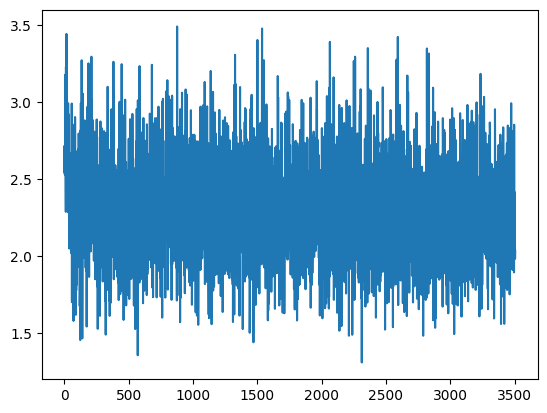

In [66]:
plt.plot(history["train_losses"][0])

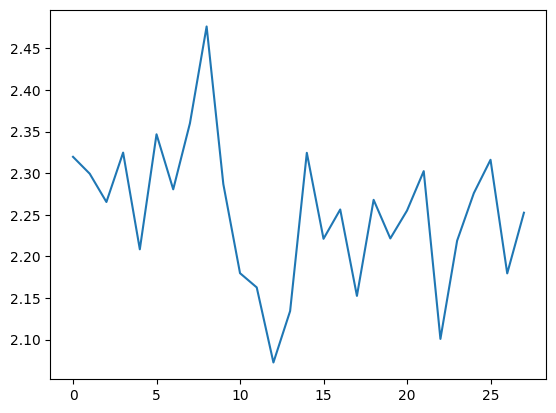

In [67]:
plt.plot(history["val_losses"][0])

In [68]:
torch.save(model_frozen.state_dict(), Path("models/model_frozen.bin"))

In [69]:
import csv

import collections

counter = collections.defaultdict(int)
for row in history:
    counter[row[1]] += 1
for row in history:
    if counter[row[1]] >= 4:
        writer = csv.writer(open("test1.csv", "wb"))
        writer.writerows(row)

TypeError: a bytes-like object is required, not 'str'

In [70]:
print(history)

{'train_acc_emo': [0.0009834996280027313, 0.0010599374229252234], 'train_acc_tri': [0.635870728401227, 0.6465720196903759], 'train_losses': [[2.5428249835968018, 2.6513595581054688, 2.715092182159424, 2.60227632522583, 2.6471805572509766, 2.525808811187744, 2.7470970153808594, 2.682197093963623, 3.1777071952819824, 2.7035601139068604, 2.6492581367492676, 2.505561351776123, 2.285585880279541, 3.227919816970825, 3.1521334648132324, 2.7018024921417236, 2.488055944442749, 3.441784381866455, 2.430772066116333, 2.3820338249206543, 2.3196449279785156, 3.000251293182373, 2.582620620727539, 2.3781254291534424, 2.4564332962036133, 2.379429817199707, 2.931521415710449, 2.4810142517089844, 2.6725564002990723, 2.2827911376953125, 2.9914870262145996, 2.7254323959350586, 2.411952018737793, 2.39762544631958, 2.413219690322876, 2.883876323699951, 2.9174556732177734, 2.231632947921753, 2.413625717163086, 2.046882152557373, 2.5264124870300293, 2.2029590606689453, 2.4285173416137695, 2.1828203201293945, 2

## FULL


In [72]:
model_full, optimizer = setup(learning_rate=5e-5, frozen=False)

In [73]:
history = train_eval(
    train_dl,
    validation_dl,
    model=model_full,
    optimizer=optimizer,
    n_epochs=1,
    save_name=f"test_model",
)

Epoch 1/1


  0%|          | 0/3505 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

train_loss=1.4247, val_loss=0.7833, train_acc_emo=0.0020, train_acc_tri=0.7284,val_acc_emo=0.0000, val_acc_tri=0.8571, 


In [74]:
print(history)

{'train_acc_emo': [0.002048532903922788], 'train_acc_tri': [0.7283655561104373], 'train_losses': [[3.1255860328674316, 2.5966567993164062, 2.7616164684295654, 2.6584901809692383, 2.67506742477417, 2.6097216606140137, 2.5404157638549805, 2.435786247253418, 2.3591442108154297, 2.3595752716064453, 2.3614795207977295, 2.7424609661102295, 2.440967559814453, 2.2686493396759033, 2.563549757003784, 2.62497878074646, 2.299018383026123, 2.52905011177063, 2.0613205432891846, 2.2089428901672363, 2.4624626636505127, 1.9509936571121216, 2.839550018310547, 2.4089934825897217, 1.9880728721618652, 2.216214179992676, 2.303041696548462, 2.0331056118011475, 2.7668166160583496, 2.59971022605896, 2.1178247928619385, 2.837413787841797, 2.1706743240356445, 2.3383889198303223, 2.391990900039673, 2.153859853744507, 2.9689056873321533, 1.7219924926757812, 2.2957425117492676, 2.137138605117798, 2.0088768005371094, 2.6304757595062256, 2.1384198665618896, 2.6701724529266357, 1.3888338804244995, 2.118718385696411, 2

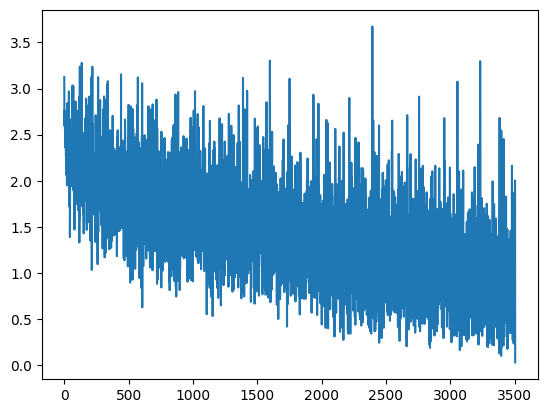

In [75]:
plt.plot(history["train_losses"][0])

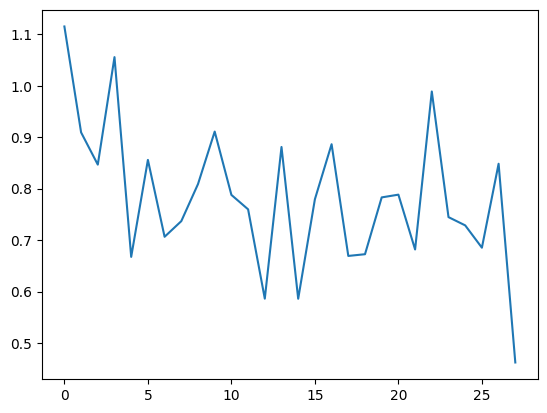

In [76]:
plt.plot(history["val_losses"][0])

tensor [[utt + pad], [utt + pad], [utt + pad]]
tensor [CLS + utt + SEP + utt + SEP + utt + SEP + pad]
[ tensor[cls utt padd] tensor [cls utt padd]]


## Training con Classe Trainer

In [77]:
class BertTrainer(Trainer):
    def __init__(self, model, training_args, train_ds, eval_ds, metrics):
        super().__init__(model, training_args, train_ds, eval_ds, metrics)

    def compute_loss(self, model, inputs, return_outputs=False):

        ids = inputs["input_ids"]
        mask = inputs["attention_mask"]
        emotions_labels = inputs["emotions"]
        triggers_labels = inputs["triggers"]
        output_emotions, output_triggers = model(ids=ids, mask=mask)

        custom_loss = self.loss_fn(
            output_emotions, output_triggers, emotions_labels, triggers_labels
        )

        return (
            (custom_loss, output_emotions, output_triggers)
            if return_outputs
            else custom_loss
        )

    def loss_fn(outputs_emotions, outputs_triggers, emotions_labels, triggers_labels):
        return torch.nn.CrossEntropyLoss(
            outputs_emotions, emotions_labels
        ) + torch.nn.BCELoss(outputs_triggers, triggers_labels)

In [78]:
trainer.train()

NameError: name 'trainer' is not defined